### Building RAG system to find out faulty or not semiconductor
dataset:  https://archive.ics.uci.edu/dataset/179/secom
- Modern semiconductor manufacturing involves continuous monitoring using sensor signals or process measurement points.

- Not all monitored signals are equally valuable; they may contain useful data, irrelevant information, and noise.

- Often, useful data is hidden within irrelevant information and noise.

- Engineers typically collect more signals than necessary.

- Feature selection helps identify the most relevant signals (features) for analysis.

- Selected features assist Process Engineers in identifying key factors causing yield issues in production.

- Benefits include:

    - Improved process throughput

    - Reduced time to learning

    - Lower per-unit production costs

- Feature selection is being explored as an intelligent systems technique to support business improvement.

- The dataset includes:

    - Individual production instances (entities)

    - Associated measured features

    - Labels indicating pass (.1) or fail (1) outcomes from in-house testing

    - Date-time stamps corresponding to the test point-

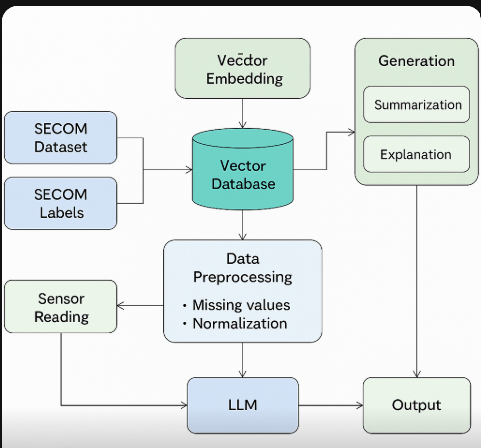

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## prompt : Given the following sensor readings and the 5 most similar historical examples, summarize the differences and indicate if the current sample is likely faulty

## 1. load the datasets

In [2]:
import pandas as pd

# data: 1576, features: 591
data = pd.read_csv("/content/drive/MyDrive/RAG Q&A System/semoconductor_data/data/secom/secom.data", delim_whitespace=True, header = None)

label_df = pd.read_csv("/content/drive/MyDrive/RAG Q&A System/semoconductor_data/data/secom/secom_labels.data", sep = ' ', header = None)



<ipython-input-2-e984d29b4a26>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv("/content/drive/MyDrive/RAG Q&A System/semoconductor_data/data/secom/secom.data", delim_whitespace=True, header = None)


In [3]:
print(data.shape)
print(label_df.shape)

(1567, 590)
(1567, 2)


In [4]:
# changing the features for example 0 to feature_0
old_labels = list(data.columns)
type(old_labels)
new_labels = ["feature_"+str(i) for i in range(0,591)]
type(new_labels)
data.rename(columns=dict(zip(old_labels, new_labels)), inplace = True)

In [5]:
x = list(i for i in range(0,5))
y = list(i for  i in range(5,9))
dc = dict(zip(x,y))
dc

{0: 5, 1: 6, 2: 7, 3: 8}

In [6]:
print(zip(x, y))

In [7]:
# rename label data
label_df.rename(columns={0: "label", 1:"timestamp"}, inplace=True)

In [8]:
label_df["label"].value_counts()
# 1 :  faulty
# -1 : not faulty

,count
label,
-1,1463
1,104


In [9]:
label_df.sample(1)

,label,timestamp
1309,-1,05/10/2008 05:31:00


In [10]:
# createed 2 df, without preprocess, with preprocess
data_wo_preprocess = data.copy()
data_for_process = data.copy()
## handling nan value by imputing mean
data_for_process.fillna(data.mean(), inplace=True)
data_for_process.sample()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_580,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589
955,2892.86,2538.74,2197.3222,1586.9476,2.0983,100.0,97.6267,0.1249,1.562,0.0069,...,0.0022,31.8749,0.499,0.0128,0.0036,2.5692,0.0208,0.0066,0.0022,31.8749


In [11]:
print(data_wo_preprocess.isnull().values.any())
print(data_for_process.isnull().values.any())

True
False


#### scalling the data
- important if you're creating numerical embeddings using PCA, UMAP, or ML models before storing in the vector database.

In [12]:
import numpy as np

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# scalling the data
# pre_scalled = data
scalled_data = scaler.fit_transform(data_for_process)
# print(scalled_data)
# convert to data frame
scalled_dataframe = pd.DataFrame(scalled_data, columns = data.columns, dtype=np.float32)
# scalled_dataframe = scalled_dataframe.round(4)

In [14]:
# checkong if there is any index mismatching or not
(scalled_dataframe.index == label_df.index).all()

np.True_

In [15]:
scalled_dataframe.head()
# data_after_process = pd.concat([scalled_dataframe, label], axis = 1)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_580,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589
0,0.224309,0.849725,-0.436273,0.033555,-0.050580,0.0,-0.563790,0.266269,0.509826,1.128417,...,4.436053e-16,2.587617e-16,0.118699,-0.204890,-0.093207,-0.197113,0.000000,0.000000,6.054371e-16,1.514500e-16
1,1.107136,-0.382910,1.017137,0.153067,-0.060045,0.0,0.198217,0.322244,0.456999,0.022582,...,3.089342e-01,2.007880e+00,0.530203,0.406679,0.444706,0.385059,-0.960174,0.411853,2.501244e-01,1.156689e+00
2,-1.114158,0.799102,-0.481289,0.686213,-0.047906,0.0,-0.906210,0.255074,-0.260907,0.327183,...,4.809624e+00,-2.744817e-01,-1.262780,0.022264,0.014375,0.029833,2.991151,3.627063,3.321419e+00,-1.791486e-01
3,-0.350312,-0.198875,-0.051547,-1.106948,-0.051290,0.0,0.503246,-0.013602,0.343218,-0.765408,...,-5.093731e-01,-4.386698e-01,-0.322199,-0.292257,-0.362164,-0.283417,-0.101895,-0.178927,-3.082928e-01,-2.752459e-01
4,0.242143,0.087526,1.117387,-0.158919,-0.047492,0.0,-0.115382,0.187905,0.545044,-0.149584,...,4.436053e-16,2.587617e-16,-5.906899,26.867231,27.071424,26.913347,-0.101895,-0.178927,-3.082928e-01,-2.752459e-01


In [ ]:
# data_after_process.sample(2)

In [ ]:
## now will create prompt from scalled_dataframe and data_wo_preprocess
## label from label data

## prompt creation:
Sensor Log - Timestamp: [timestamp]

Original Sensor Readings:
[feature_1]: [raw_value_1], [feature_2]: [raw_value_2], ..., [feature_n]: [raw_value_n]

Processed Sensor Readings (NaNs filled, standardized):
[feature_1]: [scaled_value_1], [feature_2]: [scaled_value_2], ..., [feature_n]: [scaled_value_n]

System Status: [Faulty / Not Faulty]

In [16]:
label_df.index

RangeIndex(start=0, stop=1567, step=1)

In [49]:
# list_columns = list(data_wo_preprocess.columns)
# list_columns = list_columns[0:-2]

In [38]:
#def create_prompt_column(data_wo_preprocess, scalled_dataframe, label_df)
prompts = []
labels = []
for i in range(0,1567):
  raw_data = ", ".join([f"{col}: {data_wo_preprocess.iloc[i][col]}" for col in data_wo_preprocess.columns])
  scaled_data = ", ".join([f"{col}: {scalled_dataframe.iloc[i][col]:.4f}" for col in scalled_dataframe.columns])
  label = "Faulty" if label_df.iloc[i]["label"] == 1 else "Not Faulty"
  timestamp = label_df.iloc[i]["timestamp"]

    # intro = ""
    # abstract = "Data is given from  a semi-conductor manufacturing process. "

    # intro_blurb = f"\n{intro}"
    # abstract_blurb = f"\n{abstract}"
    # prompt_intro =

  prompt = f""" You are a semiconductor sensor specialist. Below is a sensor log and system status. Analyze and summarize the key details. Asses the system status.Sensor Log - Timestamp: {timestamp}.Original Sensor Readings:{raw_data}.Processed Sensor Readings (Nan Filled wil mean value, standardizes):{scaled_data}.System Statue: {label}
  """
  # prompts[i] = prompt
  prompts.append(prompt)
  labels.append(label)

# return prompts

# print(raw_data)
# print(scaled_data)
# print(label)
# print(timestamp)
#prompts

In [18]:
# print(scalled_dataframe.iloc[145])
# print(label_df.iloc[145])

In [39]:
print(prompts[1566]) # 1 prompt with 24740 - 24750 tokens
print(labels[145])

 You are a semiconductor sensor specialist. Below is a sensor log and system status. Analyze and summarize the key details. Asses the system status.Sensor Log - Timestamp: 17/10/2008 06:07:00.Original Sensor Readings:feature_0: 2944.92, feature_1: 2450.76, feature_2: 2195.4444, feature_3: 2914.1792, feature_4: 1.5978, feature_5: 100.0, feature_6: 85.1011, feature_7: 0.1235, feature_8: nan, feature_9: nan, feature_10: nan, feature_11: nan, feature_12: nan, feature_13: nan, feature_14: nan, feature_15: nan, feature_16: nan, feature_17: nan, feature_18: nan, feature_19: 12.479, feature_20: 1.4048, feature_21: -5319.5, feature_22: 2668.0, feature_23: -3951.75, feature_24: -425.0, feature_25: 1.302, feature_26: 2.0085, feature_27: 7.3395, feature_28: 73.0667, feature_29: 2.5889, feature_30: 0.2021, feature_31: 3.386, feature_32: 83.3424, feature_33: 8.7786, feature_34: 50.194, feature_35: 64.2226, feature_36: 49.806, feature_37: 66.2251, feature_38: 86.4039, feature_39: 120.5418, feature_40

In [41]:
# prompts[1566]

In [42]:
# !pip install langchain faiss-cpu langchain-community
from langchain.schema import Document

In [43]:
# prompts = """This is my prompt"""
# label = "yes"
documents = [Document(page_content=prompt, metadata={"label":label}) for prompt, label in zip(prompts, labels)]

In [45]:
# documents[0].page_content

In [46]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"

In [24]:
!pip install -q langchain langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00


In [25]:
## embedding- hugging-face embedding
# !pip install langchain-huggingface
from langchain.embeddings import HuggingFaceEmbeddings

embedding = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")

<ipython-input-25-fb7696bddc65>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

##  creating vector db taking time, so decided to chunking:

1. scalled_df rounded to 4 folating point, during prompt creation.
2. tried with full prompt, but later when i will use llm it may not work because of the token limit.
3. trying to chunk the prompt... but it may lose some semantic meaning.
4. may PCA works , as i found out that only 204 features can get the 98% variance of the data.


In [26]:
!pip install faiss-gpu-cu12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [47]:
# creating vector db taking time, so decided to chunking
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)

chunk_docs = splitter.split_documents(documents)

In [48]:
len(chunk_docs)

81380

In [32]:
# chunk_text = [doc.page_content for doc in chunk_docs]

In [51]:
# chunk_docs[0:2]

[Document(metadata={'label': 'Not Faulty'}, page_content='You are a semiconductor sensor specialist. Below is a sensor log and system status. Analyze and summarize the key details. Asses the system status.Sensor Log - Timestamp: 19/07/2008 11:55:00.Original Sensor Readings:feature_0: 3030.93, feature_1: 2564.0, feature_2: 2187.7333, feature_3: 1411.1265, feature_4: 1.3602, feature_5: 100.0, feature_6: 97.6133, feature_7: 0.1242, feature_8: 1.5005, feature_9: 0.0162, feature_10: -0.0034, feature_11: 0.9455, feature_12: 202.4396, feature_13: 0.0, feature_14:'),
 Document(metadata={'label': 'Not Faulty'}, page_content='feature_13: 0.0, feature_14: 7.9558, feature_15: 414.871, feature_16: 10.0433, feature_17: 0.968, feature_18: 192.3963, feature_19: 12.519, feature_20: 1.4026, feature_21: -5419.0, feature_22: 2916.5, feature_23: -4043.75, feature_24: 751.0, feature_25: 0.8955, feature_26: 1.773, feature_27: 3.049, feature_28: 64.2333, feature_29: 2.0222, feature_30: 0.1632, feature_31: 3.5

In [27]:
## A vector store stores embedded data and performs similarity search.

## if takes time , should I chunk docs

from langchain.vectorstores import FAISS


In [61]:
chunk_docs[0] # type : list

Document(metadata={'label': 'Not Faulty'}, page_content='You are a semiconductor sensor specialist. Below is a sensor log and system status. Analyze and summarize the key details. Asses the system status.Sensor Log - Timestamp: 19/07/2008 11:55:00.Original Sensor Readings:feature_0: 3030.93, feature_1: 2564.0, feature_2: 2187.7333, feature_3: 1411.1265, feature_4: 1.3602, feature_5: 100.0, feature_6: 97.6133, feature_7: 0.1242, feature_8: 1.5005, feature_9: 0.0162, feature_10: -0.0034, feature_11: 0.9455, feature_12: 202.4396, feature_13: 0.0, feature_14:')

In [62]:
# converting the chunk doc into np_array
# embed_document() expect list of string not Document
texts = [doc.page_content for doc in chunk_docs] # type: list
embeddings = embedding.embed_documents(texts)
embeddings_np = np.array(embeddings, dtype = np.float32)

In [65]:
embeddings_np.shape # 768

(81380, 768)

In [66]:
# embeddings = embedding.embed_documents(chunk_docs)
# embeddings_np = np.array(embeddings, dtype = np.float32)

In [ ]:
# db = FAISS.from_embeddings(text_embeddings=list(zip([doc.page_content for doc in chunk_docs], embeddings_np)), embedding=embedding)#
db = FAISS.from_documents(chunk_docs, embedding)

In [ ]:
# save in local
db.save_local("fiasis_index_chunk") # chunked doc
# load from local
# db = FAISS.load_local("fiasis_index_chunk", embedding)

### 2. Embedding or dimensionality reduction
 - without embedding, vector similarity search will be impossible. Which is core part of RAG

In [ ]:
!pip install numpy scikit-learn

In [67]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# before applying pca
pca = PCA().fit(scalled_dataframe)
comulative_var = pca.explained_variance_ratio_.cumsum()

threshold = 0.98
val = np.where(comulative_var >= threshold)[0][0]+1
val

np.int64(204)

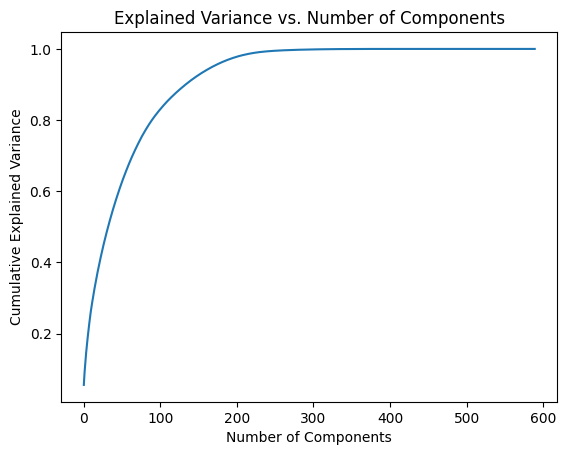

In [69]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [70]:
# apply pca
n_components = 204
best_pca = PCA(n_components = n_components)
embeddings = best_pca.fit_transform(scalled_dataframe)

In [74]:
scalled_dataframe.iloc[0]

,0
feature_0,2.243090e-01
feature_1,8.497245e-01
feature_2,-4.362730e-01
feature_3,3.355504e-02
feature_4,-5.058046e-02
...,...
feature_585,-1.971129e-01
feature_586,0.000000e+00
feature_587,0.000000e+00
feature_588,6.054371e-16


In [72]:
embeddings[0]

array([-1.6883287e+00,  2.8817360e+00,  3.7874870e+00, -2.6559167e+00,
       -6.5099591e-01, -1.1791729e+00, -1.8101416e+00,  1.7738577e+00,
       -1.5710467e-02, -1.7771984e+00,  1.4230610e+00,  4.5569882e+00,
       -4.3154863e-01,  8.3450097e-01, -4.0829949e+00, -5.2775693e+00,
       -3.1172657e+00, -2.8881505e+00,  2.5330291e+00, -1.4984952e+00,
        3.3694198e+00,  1.2896855e-01,  2.4263446e+00, -2.5127053e+00,
       -5.5000490e-01,  2.8084803e+00, -4.4752124e-01,  3.2842286e+00,
       -1.0489917e+00,  7.8963630e-02, -3.4304624e+00,  2.5463688e+00,
        7.2626543e-01,  3.0600994e+00, -1.5042106e+00,  2.9505119e+00,
       -1.2050284e+00,  3.2338890e-01, -7.1114510e-01,  1.8513840e+00,
       -4.2103812e-01,  1.1117533e+00,  1.7382647e-01, -2.4063759e-01,
        5.4961753e-01,  1.4905543e+00,  2.2703846e+00, -1.0587518e+00,
        5.0144178e-01,  1.5657520e-01, -6.9581395e-01, -7.3218822e-01,
        6.8636864e-01,  4.8341116e-01,  1.6718934e+00, -6.5869725e-01,
      

In [ ]:
embeddings.shape

(1567, 204)

In [ ]:
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain.embeddings.base import Embeddings

In [ ]:
# class embed(embeddings):
#   def __init__(self, vector):
#     self.vector = vector
#   def embed_documents(self, text):
#     return self.vector
#   def embed_query(self, text):
#     return self

Now what have I done? I have done this:
scaled_data_label_for_doc = pd.concat([scalled_dataframe, label], axis = 1)
where scaled dataframe shape is 1567 by 590
and embedding is np array and shape is (1567, 204)

So my question is, scaled label data has more features than embeddings, so will it be problematic for similarity search if I pass the scaled data (1567 by 590) with label inot document and embedding as embedding data, which has shape: (1567, 204) . can you give me answer in short and precious

In [ ]:
# for creating doc, i will first marge the scaled_datafraem and label, then convert it inot the document. I have embedding of the features, which was done by pca. I will pass that embedding
scaled_data_label_for_doc = pd.concat([scalled_dataframe, label], axis = 1)
# drop column timestamp
scaled_data_label_for_doc.drop(columns = ['timestamp'], inplace = True)

In [ ]:
embeddings.shape

(1567, 204)

In [ ]:
documents = [
    Document(
        page_content="Sensor reading data after StandardScaling " + str(i) + ":" + str(row[1].drop("label").values.tolist()),
        metadata={"label": int(row[1]["label"])}
    )

    for i, row in enumerate(scaled_data_label_for_doc.iterrows())
]



In [ ]:
# documents[0]

In [ ]:
# for i, row in enumerate(scaled_data_label_for_doc.iterrows()):
#   if i <= 2:
#     # print(row)
#     print(row[1]["label"])
type(embeddings)

numpy.ndarray

In [ ]:
# created documents from the scaled data and label
documents[0]

Document(metadata={'label': -1}, page_content='Sensor reading data after StandardScaling 0:[0.22430902093636199, 0.8497245455534013, -0.436273028037545, 0.03355503763252804, -0.05058045744618522, 0.0, -0.5637900930104123, 0.26626930473900745, 0.5098264214972222, 1.128416536545573, -0.3815426507413949, -1.5154813463004728, 0.762959920108442, 0.0, -0.37578286171637104, 0.10378243587922958, 0.05652173487363354, -0.2858739728182255, 0.845708650074628, 0.17479843677595439, -0.14668322602367456, 0.3184072928240247, 0.7354679537547316, -0.17221012127585938, 0.36194159863923847, -1.7378349499180046, -0.8740884585006319, -2.8877405489209993, -1.522971708496811, -0.8425057286355293, -0.6368091809864455, -0.2881203350586298, -0.9580858737097916, 0.4110763859335697, 0.029073948189246412, -0.11541971326291202, -0.029081603092864054, 0.3054037217749082, 0.26636354499846115, -0.6457979040974785, -0.2771197385149884, 0.4962305571742278, 0.0, -0.45285308622588044, 0.8742846602731205, -0.812565959271983

### 3. Vector db

In [ ]:
# embeddings[0]
# Dummy class to bypass LangChain's Embeddings interface
class DummyEmbeddings(Embeddings):
    def __init__(self, vectors):
        self.vectors = vectors
    def embed_documents(self, texts):
        return self.vectors
    def embed_query(self, text):
        return self.vectors[0]  # Just an example

In [ ]:
dummy_embeddings = DummyEmbeddings(embeddings)

In [ ]:
dummy_embeddings

In [ ]:
db = FAISS(embedding_function= DummyEmbeddings(embeddings))

ValidationError: 1 validation error for Document
page_content
  Input should be a valid string [type=string_type, input_value=Document(metadata={'label....5145001106248855e-16]'), input_type=Document]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type

### 4. LLM

### 5. RAG framework